# Using the NetCDF library

## Review

OK, let's review what we've learned so far with our experiments

* Read rate is inversely proportional to slice fragmentation
* Reading from RAM is really, really fast (after paying the initial cost)

In the first section, we only performed I/O with a simple multidimensional array. Let's explore the usage of the NetCDF library and investigate what it provides for us.

In [1]:
import os
from tempfile import mkstemp

import netCDF4
from matplotlib import pyplot
%matplotlib inline

Let's start by creating an empty NetCDF file to contain the same array that we had computed before. Then we'll iteratively compute the array and write it out to the NetCDF.

In [2]:
_, filename = mkstemp(suffix='.nc', dir=os.getcwd())

shape = (256, 1024, 1024)

nc = netCDF4.Dataset(filename, 'w', format='NETCDF3_CLASSIC')
nc.createDimension('x', shape[2])
nc.createDimension('y', shape[1])
nc.createDimension('z', shape[0])
some_var = nc.createVariable('some_variable','f4',('z', 'y', 'x'))

In [3]:
print(some_var.dimensions, some_var.shape)

('z', 'y', 'x') (256, 1024, 1024)


In [4]:
import numpy as np
import math

def f(x, y, z):
    d = math.sqrt((x - 256) ** 2 + (y - 256) ** 2)
    return math.sin(d / 64) + math.sin(z)
f_v = np.vectorize(f)

x, y = np.meshgrid(range(shape[2]), range(shape[1]))
basegrid = f_v(x, y, 0).astype('float32')

for z in range(shape[0]):
    a = basegrid + math.sin(z / 32)
    some_var[z,:,:] = a


In [5]:
!ls -l $filename

-rw------- 1 james james 1073741948 May  1 08:20 /home/james/code/git/netcdf-tutorial/notebooks/tmp2yoejl.nc


In [6]:
1073741948 - 2 ** 30

124

So a classic NetCDF3 is essentially just the array that we built in part 1 with a few bytes of header appended to the beginning. I wonder whether our same access methods would work? Let's try. We'll try and extract the first 1024 * 1024 cells, which should equivalent to our basegrid. So it should look like this:

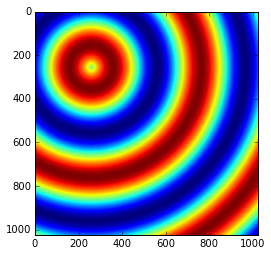

In [7]:
pyplot.imshow(basegrid)

/home/james/code/git/netcdf-tutorial/env/lib/python3.3/site-packages/numpy/ma/core.py:2244: RuntimeWarning: invalid value encountered in isfinite
  condition = ~(np.isfinite(a))


/home/james/code/git/netcdf-tutorial/env/lib/python3.3/site-packages/matplotlib/colors.py:925: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/home/james/code/git/netcdf-tutorial/env/lib/python3.3/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


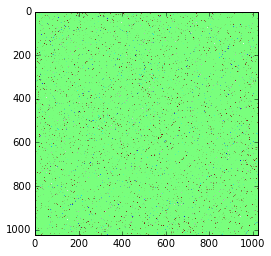

In [8]:
with open(filename, 'rb') as nc_file:
    nc_file.seek(124)
    bytes_ = nc_file.read(1024 * 1024 * 4)

a = np.fromstring(bytes_, np.dtype('float32')).reshape((1024, 1024))
pyplot.imshow(a)


*That's* not right. What's going on here? It turns out that NetCDF byte order, or *endianness* is reversed from the standard C byte order. For example, if the four bytes of a number were in C were 16bf a50f 18bf 5a57, then in NetCDF they are stored as: 5a57 18bf a50f 16bf.

`numpy` is written by people who handle this sort of confusion all of the time, so there's any easy way to deal with this. Just call the array's `byteswap` method, and it will reverse the bytes for you (sort of, technically it's possible to just change an attribute that specifies whether to read them in forward or reverse order).

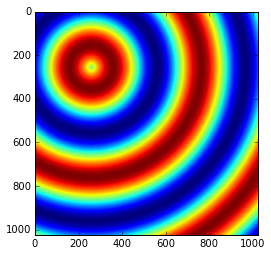

In [9]:
a = a.byteswap(True) # set inplace=True to just change the order attribute, rather than returning a copy
pyplot.imshow(a)


And there we are! We have our original array, using regular old binary read. Notice that if we ask whether the arrays are equal, we find out that they are.

In [10]:
np.all(a == basegrid)

True

I should note as an aside, that when I was preparing this tutorial, initially I found that the what I read out of NetCDF file was off from my base array somewhere in the $ 1.0 \times 10 ^ {-08} $ range. I accidentally hadn't specified the number of bytes in my original array, so it was using the native float8 (64-bit) and then converting that down to 32-bit when it stuff it in the NetCDF file. It made it *appear* as though I was losing preicision through the round trip to/from the file, but really I had lost it before-hand.

## File I/O with the NetCDF library

In any case, we've demonstrated that a classic NetCDF3 file is nothing more than an ordinary byte array with a header at the beginning. Does it do any better at file I/O than we could with our regular Python implementation?


In [11]:
some_var.dimensions, some_var.shape

(('z', 'y', 'x'), (256, 1024, 1024))

In [12]:
%%timeit
a = some_var[:,:,:]

1 loops, best of 3: 686 ms per loop


In [13]:
a.shape

(1024, 1024)

So it's actually quite a bit faster than our naive Python implementation (by about 5 times), and *boy* is the code simpler!

Let me emphasize that point. Look at that operation `a = some_var[:,:,:]`. In just one line of code, we were able to express that we wanted to pull an arbitrary hyperslab of data out of a file and put it into an equivalent multidimensional array. The code to do this that we wrote in the first section was over 20 lines long, wasn't as good and wasn't as fast. *This* is what using the NetCDF library gives you. It gives the power of higher level abstractions, which allow you to write less than 5% of the code that you would otherwise write. That's totally worth it.

And in this case, the higher level code is actually faster. That won't always be the case, but if you only have to write $ \frac{1}{20} $ of the code that you otherwise would, then that gives you a lot of extra time to optimize later on *if you have to*.

Let's see how it does at various other types of slicing operations. We'll set up an experiment here, where we create a temporary NetCDF file, and then we'll time how long it takes to perform slices on each set of axes. These are all of the slicing edge cases: getting one point in one dimension and everything else in the other dimensions. This set of slices should cover the full gamut of operations that one might want to do.

In [14]:
from timeit import repeat

# Create the NetCDF file before we start timing
setup = '''
from tempfile import NamedTemporaryFile
import netCDF4
import os
import numpy as np

shape = (256, 256, 256)

with NamedTemporaryFile(suffix='.nc', dir=os.getcwd(), delete=False) as tmp:
    filename = tmp.name
    nc = netCDF4.Dataset(filename, 'w', format='NETCDF3_CLASSIC')
    nc.createDimension('x', shape[2])
    nc.createDimension('y', shape[1])
    nc.createDimension('z', shape[0])
    some_var = nc.createVariable('some_variable','f4',('z', 'y', 'x'))
    some_var[:,:,:] = np.empty(shape, dtype='float32')
    nc.close() # Flush the data out
nc = netCDF4.Dataset(filename, 'r')
some_var = nc.variables['some_variable']
'''
stmt = '''a = some_var[{}]
os.unlink(filename)
'''
slices = [(slice(None), slice(None), slice(None)), # Everything
          (slice(None), slice(None), slice(0, 1)), # All latitudes through time
          (slice(None), slice(0, 1), slice(None)), # All longitudes through time
          (slice(0,1), slice(None), slice(None)), # Slice of space (i.e. a map)
          (slice(None), slice(0,1), slice(0,1)), # A timeseries at a point
          (slice(0,1), slice(None), slice(0,1)), # All latitudes at t=0
          (slice(0,1), slice(0,1), slice(None)), # All longitudes at t=0
          (slice(0,1), slice(0,1), slice(0,1)) # One grid box
         ]
timings = [ repeat(stmt=stmt.format(repr(slice_)), repeat=10, setup=setup, number=1) for slice_ in slices ]

In [15]:
timings

[[0.04692709200026002,
  0.046198419004213065,
  0.0510507119979593,
  0.04932156799623044,
  0.04889077699772315,
  0.04792966300010448,
  0.047416552995855454,
  0.048137748999579344,
  0.04848937999486225,
  0.04859320999821648],
 [0.01284546699753264,
  0.012430078997567762,
  0.013656652001373004,
  0.012985417997697368,
  0.01270084499992663,
  0.012256832000275608,
  0.011886940003023483,
  0.011804541005403735,
  0.01176169200334698,
  0.011854641001264099],
 [0.0008258279995061457,
  0.0007533570023952052,
  0.0007461819986929186,
  0.0007108469944796525,
  0.0007312099987757392,
  0.0007221470004878938,
  0.0007220330007839948,
  0.0007186739967437461,
  0.0007094359971233644,
  0.0007585999992443249],
 [0.0004135069975745864,
  0.00041511400195304304,
  0.00045391299499897286,
  0.0004190279942122288,
  0.0004142769976169802,
  0.00042755200411193073,
  0.0004268789998604916,
  0.0004233110012137331,
  0.0004283230009605177,
  0.00041223899461328983],
 [0.0006168079999042675

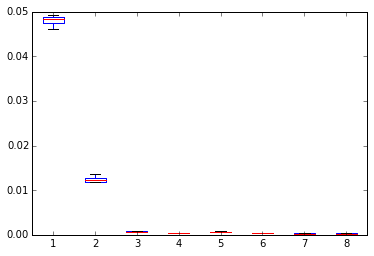

In [16]:
plots = pyplot.boxplot(timings, showfliers=False)

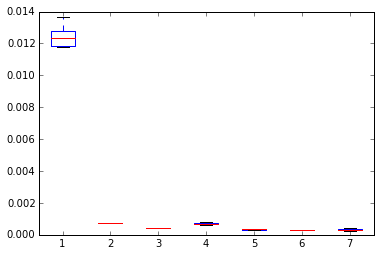

In [17]:
plots = pyplot.boxplot(timings[1:], showfliers=False)

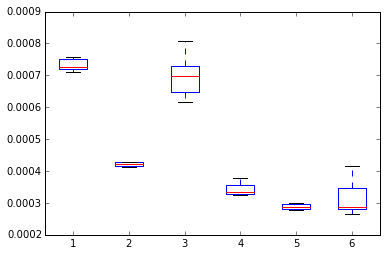

In [18]:
plots = pyplot.boxplot(timings[2:], showfliers=False)

So the plots above show us a few things, but don't necessarily tell the whole story. The plots show the time that it takes to read a particular slice. We can see that:

* Reading all of the data takes a lot longer than the rest.
* Reading all latitudes through time, takes a lot longer than reading all longitudes through time.
* The remaining operations are all in the same order of magnitude, but
  * A slice of time for all space is faster than a slice of space for all time
  * A slice of longitude is faster than a slice of latitude.
  
But these requests are not all equal. They are requesting different sizes of datasets, so we should also incorporate the size into our measurement and report the bytes/second or *throughput*.

In [19]:
num_bytes = [ np.empty((256, 256, 256), dtype='float32').__getitem__(slice_).nbytes for slice_ in slices ]

In [20]:
num_bytes

[67108864, 262144, 262144, 262144, 1024, 1024, 1024, 4]

In [21]:
np.array(timings).shape

(8, 10)

In [22]:
throughput = (np.array(num_bytes) / np.array(timings).transpose()).transpose().tolist()

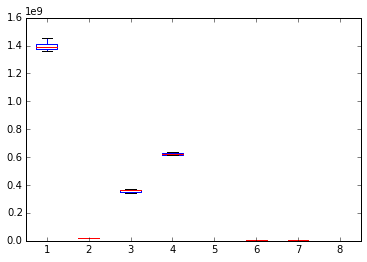

In [23]:
plots = pyplot.boxplot(throughput, showfliers=False)

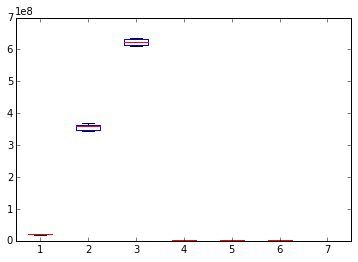

In [24]:
plots = pyplot.boxplot(throughput[1:], showfliers=False)

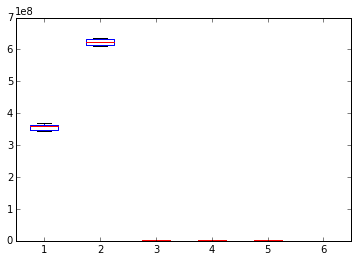

In [25]:
plots = pyplot.boxplot(throughput[2:], showfliers=False)

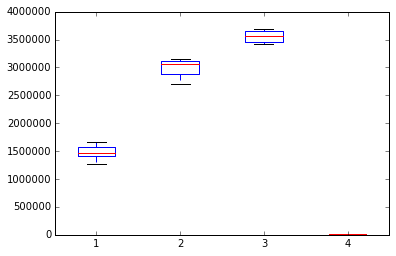

In [26]:
plots = pyplot.boxplot(throughput[4:], showfliers=False)

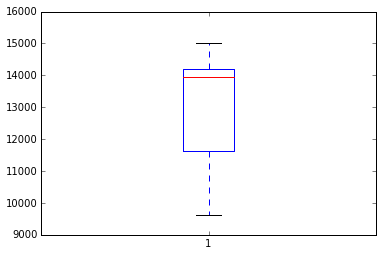

In [27]:
plots = pyplot.boxplot(throughput[7], showfliers=False)

So this tells a similar story. Good/high throughput for sequential reads and several orders of magnitude slower throughput for the cases where we're reading data in a highly fragmented manner.

## Speed comparisons: naive binary read vs. `python-netcdf4`

Going back to our initial question, "What does the NetCDF library give us?" `python-netcdf4` is just a set of Python bindings to the C NetCDF library. Conventional wisdom often specifies that "Python is 'slow'" and "C is 'fast'". Often the raw speed is irrellevant, but let's do a quick comparison of the speeds and throughput for various slicing styles.

Let's be systematic. We'll make sure that:

* A new file is recreated for each test (avoid OS caching)
* Each experiment is run 10 times

We'll use the same set of slices that we did above.

In [28]:
# Create the NetCDF file before we start timing
def setup_python_netcdf(shape = (256, 256, 256)):
    import os
    from tempfile import NamedTemporaryFile
    import netCDF4
    with NamedTemporaryFile(suffix='.nc', dir=os.getcwd(), delete=False) as tmp:
        filename = tmp.name
        nc = netCDF4.Dataset(filename, 'w', format='NETCDF3_CLASSIC')
        nc.createDimension('x', shape[2])
        nc.createDimension('y', shape[1])
        nc.createDimension('z', shape[0])
        some_var = nc.createVariable('some_variable','f4',('z', 'y', 'x'))
        some_var[:,:,:] = np.empty(shape, dtype='float32')
        nc.close() # Flush the data out
    nc = netCDF4.Dataset(filename, 'r')
    return filename, nc.variables['some_variable']

def run_python_netcdf(filename, some_var, slices):
    import os
    a = some_var[slices]
    os.unlink(filename)

# Create the binary array file and open it before we start timing
def setup_binary_array(shape = (256, 256, 256)):
    import os
    from tempfile import NamedTemporaryFile
    import numpy as np
    with NamedTemporaryFile(suffix='.nc', dir=os.getcwd(), delete=False) as tmp:
        some_var = np.empty(shape, dtype='float32')
        some_var.tofile(tmp)
        filename = tmp.name
    return open(filename, 'rb')

def run_binary_array(open_file, shape, slices):
        zn, yn, xn = shape

        def dim_length(n, slice_):
            return len(range(n)[slice_])
        
        newshape = list(dim_length(n, slice_) for n, slice_ in zip(shape, slices))
        print(newshape)
        retval = np.empty(newshape, dtype='float32')

        xi = slices[2].start or 0
        read_length = newshape[2] * np.dtype('float32').itemsize
        
        for z, zi in enumerate(range(zn)[slices[0]]):
            for y, yi in enumerate(range(yn)[slices[1]]):
                
                starting_position = ((zi * yn * xn) + yi * xn + xi) * np.dtype('float32').itemsize
                if open_file.tell() != starting_position:
                    open_file.seek(starting_position)
                bytes_ = open_file.read(read_length)
                assert len(bytes_) == read_length
                retval[z,y,:] = np.fromstring(bytes_, np.dtype('float32'))
        open_file.close
        os.remove(open_file.name)
        return retval

nclib_timings = [ repeat(setup="from __main__ import setup_python_netcdf; filename, some_var = setup_python_netcdf();",
                   stmt="from __main__ import run_python_netcdf; run_python_netcdf(filename, some_var, {});".format(repr(slice_)),
                   repeat=10, number=1) for slice_ in slices ]
binarray_timings = [ repeat(setup="from __main__ import setup_binary_array; open_file = setup_binary_array();",
                   stmt="from __main__ import run_binary_array; run_binary_array(open_file, (255, 255, 255), {});".format(repr(slice_)),
                   repeat=10, number=1) for slice_ in slices ]


[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 255, 1]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[255, 1, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[1, 255, 255]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[255, 1, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 255, 1]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 255]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]
[1, 1, 1]


In [29]:
nclib_timings

[[0.049235246995522175,
  0.050979582003492396,
  0.04846355399786262,
  0.04860842399648391,
  0.05024018899712246,
  0.04905881200102158,
  0.050613965999218635,
  0.05140408599982038,
  0.050682020002568606,
  0.05008664499473525],
 [0.012312175997067243,
  0.011997693000012077,
  0.011798698003985919,
  0.012233568995725363,
  0.013179233996197581,
  0.012788378000550438,
  0.012555339002574328,
  0.012066353003319819,
  0.01311393500509439,
  0.01265662899822928],
 [0.0007259730045916513,
  0.0007599380041938275,
  0.0007287610060302541,
  0.0008089469993137754,
  0.0007507260015700012,
  0.0007382940020761453,
  0.0007571870009996928,
  0.0007350730011239648,
  0.0007357199938269332,
  0.0007269880006788298],
 [0.0004559419976430945,
  0.0004242130016791634,
  0.0004605699941748753,
  0.0004330020019551739,
  0.00043757799721788615,
  0.0004309670039219782,
  0.00044769200030714273,
  0.0004556200001388788,
  0.0004340109953773208,
  0.0004238719993736595],
 [0.000640328005829360

In [30]:
binarray_timings

[[0.5102904890009086,
  0.5135162980004679,
  0.5047433759973501,
  0.5089178850030294,
  0.5040390259964624,
  0.5160206859945902,
  0.5106272650009487,
  0.5365073779976228,
  0.5324774339969736,
  0.535558971001592],
 [0.48222018699743785,
  0.48087635599949863,
  0.4889993569959188,
  0.48690077100036433,
  0.4724039439970511,
  0.47447314400051255,
  0.47332213600020623,
  0.49906759800069267,
  0.4793049340005382,
  0.4766735930024879],
 [0.0037457149956026115,
  0.0033441880004829727,
  0.0037444350018631667,
  0.00333711600251263,
  0.0037859439980820753,
  0.0033111290031229146,
  0.003752287993847858,
  0.0032996709996950813,
  0.0037836929986951873,
  0.0033483110019005835],
 [0.002479506001691334,
  0.0020274540001992136,
  0.0024598090021754615,
  0.002033093995123636,
  0.0024603810015833005,
  0.0020808000044780783,
  0.0024815069991745986,
  0.0020270879977033474,
  0.002447175000270363,
  0.0020302730044932105],
 [0.0035820170014631003,
  0.0031553349981550127,
  0.003

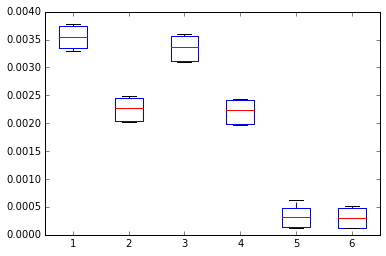

In [31]:
plots = pyplot.boxplot(binarray_timings[2:], showfliers=False)

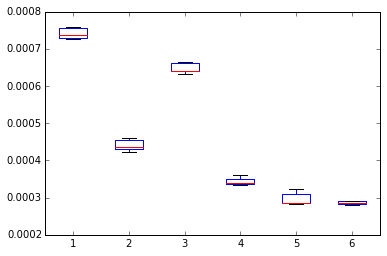

In [32]:
plots = pyplot.boxplot(nclib_timings[2:], showfliers=False)

Once again, you can see that the NetCDF library performs about 5 times faster across the board. Let's forget about our original code to perform the binary reads and just use the NetCDF library. However, keep in mind what we learned from the binary reads: there's nothing magic about NetCDF files. It's just a big binary array with a header of some metadata prepended to the beginning.